Full ML pipeline

Goal: predict aqi from "Preliminary Data Analysis and Feasibility Summary.csv"
Steps:

#Step 1 — Import Libraries & Define Metrics




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmse(y, p): return np.sqrt(mean_squared_error(y, p))
def mae(y, p): return mean_absolute_error(y, p)
def mape(y, p): return np.mean(np.abs((y - p)/(y+1e-8))) * 100
np.random.seed(42)



#Step 2 - load & peek data





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/My Drive/air_pollution_data.csv"

df = pd.read_csv(DATA_PATH).drop_duplicates().reset_index(drop=True)


rename_map = {
    "city": "City",
    "date": "Date",
    "aqi": "AQI",
    "pm2_5": "PM2.5",
    "pm10": "PM10",
    "co": "CO",
    "no": "NO",
    "no2": "NO2",
    "o3": "O3",
    "so2": "SO2",
    "nh3": "NH3"
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

SELECTED_CITIES = None


df["Date"] = pd.to_datetime(df["Date"], errors="coerce", dayfirst=True)
df = df.dropna(subset=["Date"]).copy()


df = df.sort_values(["City","Date"]).reset_index(drop=True)


for c in ["AQI","CO","NO","NO2","O3","SO2","PM2.5","PM10","NH3"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df[c] = df[c].clip(lower=0)


df["t"] = df.groupby("City").cumcount()


Mounted at /content/drive


# Step 3 — Set Forecast Target: AQI up to 3 days ahead (NO leakage)

In [ ]:
# Step 3 — Set Forecast Target: AQI exactly +3 calendar days ahead (NO leakage)
# This data doesn't include dates for every day.
# For example, in Ahmedabad, it jumps directly from 2020-12-31 to 2021-01-13.
# + Verification: compare shift(-3) vs strict +3-day where both exist

HORIZON_DAYS = 3
H = HORIZON_DAYS
label_col = f"AQI_tplus{HORIZON_DAYS}"

base = df[["City", "Date", "AQI"]].copy()
base = base.sort_values(["City", "Date"]).drop_duplicates(["City", "Date"]).reset_index(drop=True)

# -verification: mismatch rate (shift vs +3-day)
df2 = base.copy()
df2["aqi_shift"] = df2.groupby("City")["AQI"].shift(-H)

tmp = base.copy()
tmp["Date"] = tmp["Date"] - pd.Timedelta(days=H)
tmp = tmp.rename(columns={"AQI": "aqi_day"})

df2 = df2.merge(tmp[["City", "Date", "aqi_day"]], on=["City", "Date"], how="left", validate="one_to_one")

mask = df2["aqi_shift"].notna() & df2["aqi_day"].notna()
diff_rate = (df2.loc[mask, "aqi_shift"] != df2.loc[mask, "aqi_day"]).mean()
print(f"Mismatch rate between shift(-{H}) and +{H}-day:", diff_rate)

Mismatch rate between shift(-3) and +3-day: 0.003488767869298843


Since the mismatch rate between shift(-3) and the strict +3-day definition is only 0.0036 (≈0.36%), the discrepancy is negligible and can be safely ignored.”

In [ ]:
drop_like = [c for c in df.columns if c.startswith(label_col)]
df = df.drop(columns=drop_like, errors="ignore")

df_future = base.copy()
df_future["Date"] = df_future["Date"] - pd.Timedelta(days=H)
df_future = df_future.rename(columns={"AQI": label_col})

# merge into df (your full dataframe) using City+Date keys
df = df.merge(df_future[["City", "Date", label_col]], on=["City", "Date"], how="left", validate="many_to_one")

#Step 4 — Create Cyclical Time Features

In [ ]:
# The purpose of Step 4 (cyclical time features) is to help the model learn repeating
# time patterns (seasonality / weekly cycles) by encoding time in a way that reflects its circular nature.
# For example, “day 365” and “day 1” are actually close in time, and sin/cos makes that closeness visible to the model.

df["dayofweek"] = df["Date"].dt.dayofweek
df["dow_sin"] = np.sin(2*np.pi*df["dayofweek"]/7)
df["dow_cos"] = np.cos(2*np.pi*df["dayofweek"]/7)

df["dayofyear"] = df["Date"].dt.dayofyear
df["doy_sin"] = np.sin(2*np.pi*df["dayofyear"]/365.25)
df["doy_cos"] = np.cos(2*np.pi*df["dayofyear"]/365.25)

den = df.groupby("City")["t"].transform("max").replace(0, 1) + 1
df["t_sin"] = np.sin(2*np.pi*df["t"]/den)
df["t_cos"] = np.cos(2*np.pi*df["t"]/den)

# Step 5 - Feature Engineering: Lag Features + Rolling Averages

In [ ]:
lags = [1, 2, 3, 7, 14]

# lag AQI (history only; we will NOT use same-day AQI as a feature)
for lag in lags:
    df[f"AQI_lag{lag}"] = df.groupby("City")["AQI"].shift(lag)

df["AQI_roll3"] = df.groupby("City")["AQI"].transform(lambda s: s.shift(1).rolling(3).mean())
df["AQI_roll5"] = df.groupby("City")["AQI"].transform(lambda s: s.shift(1).rolling(5).mean())

# lag pollutants
pollutant_cols = ["PM2.5","PM10","CO","NO","NO2","O3","SO2","NH3"]
for col in pollutant_cols:
    if col in df.columns:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df.groupby("City")[col].shift(lag)
        df[f"{col}_roll3"] = df.groupby("City")[col].transform(lambda s: s.shift(1).rolling(3).mean())
        df[f"{col}_roll5"] = df.groupby("City")[col].transform(lambda s: s.shift(1).rolling(5).mean())

# drop rows made invalid by lag/rolling + by future target shift
df = df.dropna().reset_index(drop=True)



#Step 6 - Train/Test Split + Feature Scaling

In [ ]:
target = f"AQI_tplus{HORIZON_DAYS}"

# IMPORTANT: exclude current AQI and future target from features (avoid trivial shortcut)
exclude = {target, "AQI", "Date"}  # keep lagged AQI features though
feature_cols = [c for c in df.columns if c not in exclude]

X = df[feature_cols].copy()
y = df[target].copy()


categorical_cols = list(X.select_dtypes(include=["object"]).columns)
categorical_cols = [c for c in categorical_cols if c in X.columns]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


TEST_FRAC = 0.2
pos_in_city = df.groupby("City").cumcount()
n_in_city = df.groupby("City")["City"].transform("size")
n_test_city = (n_in_city * TEST_FRAC).astype(int).clip(lower=1)
is_test = pos_in_city >= (n_in_city - n_test_city)

X_train, X_test = X.loc[~is_test].copy(), X.loc[is_test].copy()
y_train, y_test = y.loc[~is_test].copy(), y.loc[is_test].copy()

city_train = df.loc[~is_test, "City"].values
city_test  = df.loc[is_test,  "City"].values

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

seq_len = 24
ALIGN = seq_len - 1

def valid_indices_per_city(city_arr, seq_len):
    idxs = []
    for ct in pd.unique(city_arr):
        ii = np.where(city_arr == ct)[0]
        if len(ii) < seq_len:
            continue
        idxs.extend(ii[seq_len-1:])
    return np.array(idxs, dtype=int)

valid_test_idx = valid_indices_per_city(city_test, seq_len)


In [ ]:
# This block removes samples with missing future targets (NaNs) created by the +3-day label construction,
# and then rebuilds the evaluation indices so that predictions and ground truth remain properly aligned.
train_mask = np.isfinite(np.asarray(y_train))
test_mask  = np.isfinite(np.asarray(y_test))

X_train_sc = X_train_sc[train_mask]
y_train    = y_train.loc[train_mask].reset_index(drop=True)

X_test_sc  = X_test_sc[test_mask]
y_test     = y_test.loc[test_mask].reset_index(drop=True)
city_test  = city_test[test_mask]

# rebuild valid_test_idx / y_true for aligned evaluation
valid_test_idx = valid_indices_per_city(city_test, seq_len)
y_true = y_test.values[valid_test_idx]


# Step 7 - Train Classical ML Models

In [ ]:
results = []

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_sc, y_train)
pred_lr_all = lr.predict(X_test_sc)
pred_lr = pred_lr_all[valid_test_idx]
y_true = y_test.values[valid_test_idx]
pred_lr = np.clip(pred_lr, 1, 5)  # AQI levels in this dataset are 1..5
results.append(["Linear Regression",
                rmse(y_true, pred_lr),
                mae(y_true, pred_lr),
                mape(y_true, pred_lr),
                r2_score(y_true, pred_lr)])

# Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_sc, y_train)
pred_rf_all = rf.predict(X_test_sc)
pred_rf = np.clip(pred_rf_all[valid_test_idx], 1, 5)
results.append(["Random Forest",
                rmse(y_true, pred_rf),
                mae(y_true, pred_rf),
                mape(y_true, pred_rf),
                r2_score(y_true, pred_rf)])

# XGBoost
try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_train_sc, y_train)
    pred_xgb_all = xgb.predict(X_test_sc)
    pred_xgb = np.clip(pred_xgb_all[valid_test_idx], 1, 5)
    results.append(["XGBoost",
                    rmse(y_true, pred_xgb),
                    mae(y_true, pred_xgb),
                    mape(y_true, pred_xgb),
                    r2_score(y_true, pred_xgb)])
except Exception as e:
    print("XGBoost not installed or failed:", repr(e))
    pred_xgb = None


# Step 8 - Build Time-Window Sequences for Deep Learning Models

In [ ]:
def build_seq(X_array, y_array, seq_len):
    Xs, Ys = [], []
    for i in range(0, len(X_array) - seq_len + 1):
        Xs.append(X_array[i:i+seq_len])
        Ys.append(y_array[i+seq_len-1])  # target aligned to end of window
    return np.asarray(Xs, dtype=np.float32), np.asarray(Ys, dtype=np.float32)

def build_seq_per_city(X_sc, y_arr, city_arr, seq_len):
    Xs, Ys = [], []
    for ct in pd.unique(city_arr):
        idx = np.where(city_arr == ct)[0]
        if len(idx) < seq_len:
            continue
        Xc = X_sc[idx]
        yc = y_arr[idx]
        Xc_seq, yc_seq = build_seq(Xc, yc, seq_len)
        Xs.append(Xc_seq)
        Ys.append(yc_seq)
    return np.concatenate(Xs, axis=0), np.concatenate(Ys, axis=0)

X_seq_train, y_seq_train = build_seq_per_city(X_train_sc, y_train.values, city_train, seq_len)
X_seq_test,  y_seq_test  = build_seq_per_city(X_test_sc,  y_test.values,  city_test,  seq_len)

# for DL evaluation, use y_seq_test as ground truth aligned
y_true_dl = y_seq_test




#STEP 9 — Train Deep Learning Models (LSTM / GRU / Hybrid)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout

# NOTE: Create a NEW optimizer for each model (avoid "Unknown variable" error)
EPOCHS = 12
BATCH  = 128

# LSTM
tf.keras.backend.clear_session()
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
lstm = Sequential([
    Input(shape=(seq_len, X_seq_train.shape[2])),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
lstm.compile(optimizer=opt, loss="mse")
lstm.fit(X_seq_train, y_seq_train, epochs=EPOCHS, batch_size=BATCH, verbose=0)
pred_lstm = np.clip(lstm.predict(X_seq_test, verbose=0).ravel(), 1, 5)

results.append(["LSTM",
                rmse(y_true_dl, pred_lstm),
                mae(y_true_dl, pred_lstm),
                mape(y_true_dl, pred_lstm),
                r2_score(y_true_dl, pred_lstm)])

# GRU
tf.keras.backend.clear_session()
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
gru = Sequential([
    Input(shape=(seq_len, X_seq_train.shape[2])),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])
gru.compile(optimizer=opt, loss="mse")
gru.fit(X_seq_train, y_seq_train, epochs=EPOCHS, batch_size=BATCH, verbose=0)
pred_gru = np.clip(gru.predict(X_seq_test, verbose=0).ravel(), 1, 5)

results.append(["GRU",
                rmse(y_true_dl, pred_gru),
                mae(y_true_dl, pred_gru),
                mape(y_true_dl, pred_gru),
                r2_score(y_true_dl, pred_gru)])

# Hybrid LSTM → GRU
tf.keras.backend.clear_session()
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
hybrid = Sequential([
    Input(shape=(seq_len, X_seq_train.shape[2])),
    LSTM(64, return_sequences=True),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])
hybrid.compile(optimizer=opt, loss="mse")
hybrid.fit(X_seq_train, y_seq_train, epochs=EPOCHS, batch_size=BATCH, verbose=0)
pred_hybrid = np.clip(hybrid.predict(X_seq_test, verbose=0).ravel(), 1, 5)

results.append(["Hybrid LSTM-GRU",
                rmse(y_true_dl, pred_hybrid),
                mae(y_true_dl, pred_hybrid),
                mape(y_true_dl, pred_hybrid),
                r2_score(y_true_dl, pred_hybrid)])


# Step 10 — Save Final Comparison Table

In [ ]:
results_df = pd.DataFrame(results, columns=["Model","RMSE","MAE","MAPE","R2"])
results_df = results_df.sort_values("RMSE").reset_index(drop=True)
print(results_df)
results_df.to_csv("model_comparison_results_full.csv", index=False)
print("Saved: model_comparison_results_full.csv")

               Model      RMSE       MAE       MAPE        R2
0  Linear Regression  0.968459  0.692942  26.967578  0.336485
1            XGBoost  1.013902  0.744450  29.516507  0.272758
2      Random Forest  1.023085  0.756943  30.077003  0.259524
3    Hybrid LSTM-GRU  1.103536  0.790775  30.421396  0.138489
4               LSTM  1.249584  0.875271  35.091087 -0.104635
5                GRU  1.296789  0.930587  38.212154 -0.189668
Saved: model_comparison_results_full.csv


Sanity Check / Metric Validity Check

We verified the scale of the target used in evaluation. The ground-truth labels range from 1 to 5 (mean≈3.83, std≈1.19), confirming that the task predicts a 5-level AQI category. Therefore, RMSE values around 1 are expected and roughly correspond to an average error of about one AQI level. Given the discrete nature and limited resolution of the target, classification-oriented metrics (e.g., accuracy, macro-F1, confusion matrix) are more suitable than MAPE or R² alone.



In [ ]:
print("y_true range:", float(np.min(y_true)), float(np.max(y_true)))
print("y_true mean/std:", float(np.mean(y_true)), float(np.std(y_true)))


y_true range: 1.0 5.0
y_true mean/std: 3.826923076923077 1.1889297683559108


# Step 11 — Plot Best Model Prediction vs Actual (first 300 points)

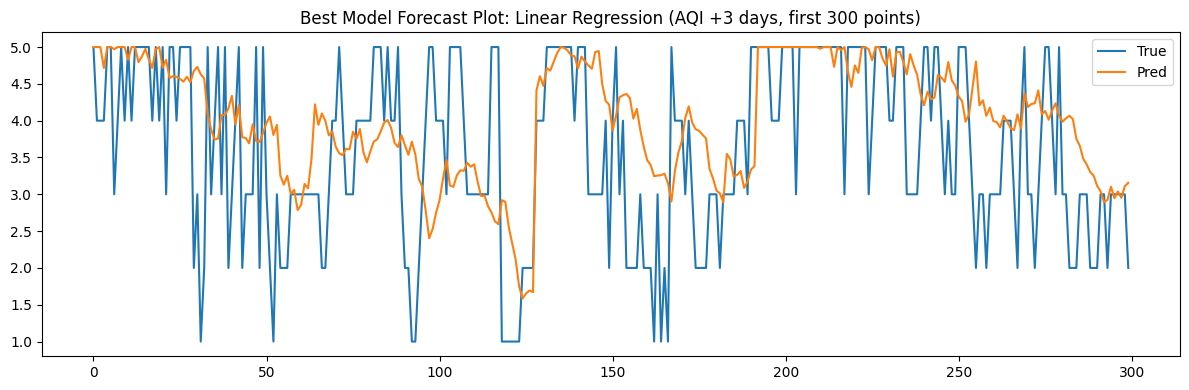

Saved: best_model_prediction_plot.png


In [ ]:
best_name = results_df.loc[0, "Model"]

# pick matching y/p for the best model (already aligned)
if best_name == "LSTM":
    y_plot, p_plot = y_true_dl, pred_lstm
elif best_name == "GRU":
    y_plot, p_plot = y_true_dl, pred_gru
elif best_name == "Hybrid LSTM-GRU":
    y_plot, p_plot = y_true_dl, pred_hybrid
elif best_name == "Random Forest":
    y_plot, p_plot = y_true, pred_rf
elif best_name == "XGBoost":
    y_plot, p_plot = y_true, pred_xgb
else:
    y_plot, p_plot = y_true, pred_lr

N = min(300, len(y_plot))
plt.figure(figsize=(12,4))
plt.plot(y_plot[:N], label="True")
plt.plot(p_plot[:N], label="Pred")
plt.title(f"Best Model Forecast Plot: {best_name} (AQI +{HORIZON_DAYS} days, first {N} points)")
plt.legend()
plt.tight_layout()
plt.savefig("best_model_prediction_plot.png", dpi=200)
plt.show()
print("Saved: best_model_prediction_plot.png")

#STEP 12 — Seasonal AQI Forecasting With Event-Based Insights”

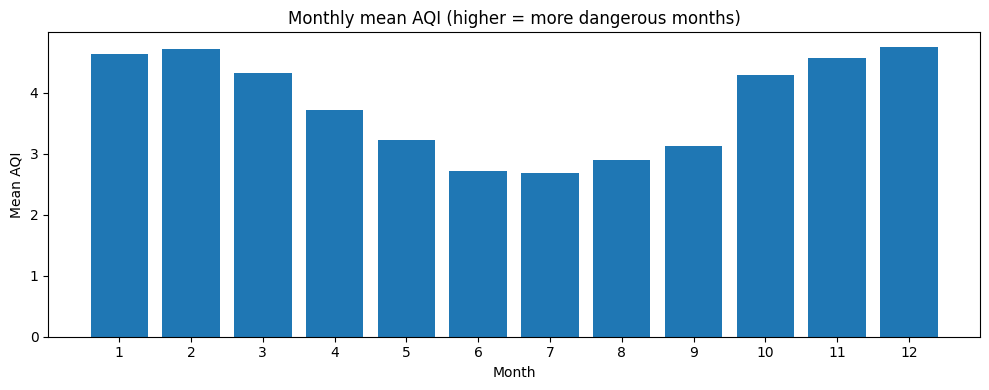

Saved: monthly_mean_aqi.png
Monthly mean AQI:
 _month
1     4.642
2     4.723
3     4.321
4     3.726
5     3.230
6     2.727
7     2.682
8     2.892
9     3.133
10    4.292
11    4.572
12    4.756
Name: AQI, dtype: float64
Diwali window (Oct20–Nov20): Event mean AQI = 4.495, Non-event mean AQI = 3.815
Crop burning window (Oct15–Nov30): Event mean AQI = 4.446, Non-event mean AQI = 3.780


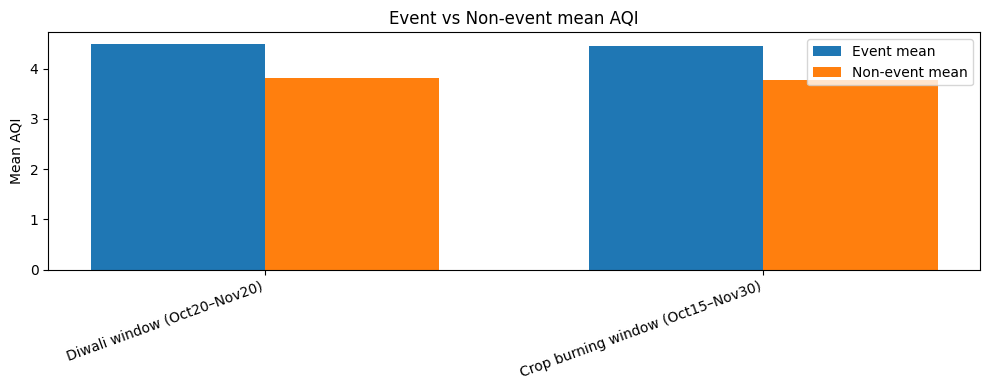

Saved: event_vs_nonevent_aqi.png

Event vs Non-event summary:
                                    Event mean  Non-event mean
Diwali window (Oct20–Nov20)             4.495           3.815
Crop burning window (Oct15–Nov30)       4.446           3.780


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


CITY_TO_PLOT = None
df_season = df.copy()
if CITY_TO_PLOT is not None and "City" in df_season.columns:
    df_season = df_season[df_season["City"] == CITY_TO_PLOT].copy()

def pick_first_existing(df_, candidates):
    for c in candidates:
        if c in df_.columns:
            return c
    lower_map = {c.lower(): c for c in df_.columns}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    return None


DATE_CANDIDATES = ["date", "Date", "datetime", "Datetime", "timestamp", "time", "Time"]
date_col = pick_first_existing(df_season, DATE_CANDIDATES)
if date_col is None:
    raise ValueError(f"No date/datetime column found. Tried: {DATE_CANDIDATES}")

dt = pd.to_datetime(df_season[date_col], errors="coerce", dayfirst=True)
if dt.isna().mean() > 0.5:
    dt = pd.to_datetime(df_season[date_col], errors="coerce", dayfirst=False)

df_season["_date"] = dt
df_season = df_season.dropna(subset=["_date"]).copy()
df_season["_month"] = df_season["_date"].dt.month
df_season["_day"]   = df_season["_date"].dt.day

# Find AQI column =====
AQI_CANDIDATES = ["AQI_Bucket", "aqi", "AQI", "Aqi"]
aqi_col = pick_first_existing(df_season, AQI_CANDIDATES)
if aqi_col is None:
    raise ValueError(f"AQI column not found. Tried: {AQI_CANDIDATES}")

df_season[aqi_col] = pd.to_numeric(df_season[aqi_col], errors="coerce")

title_city = f" ({CITY_TO_PLOT})" if CITY_TO_PLOT else ""


month_mean = df_season.groupby("_month")[aqi_col].mean()

plt.figure(figsize=(10, 4))
plt.bar(month_mean.index, month_mean.values)
plt.title(f"Monthly mean AQI (higher = more dangerous months){title_city}")
plt.xlabel("Month")
plt.ylabel("Mean AQI")
plt.xticks(range(1, 13))
plt.tight_layout()
plt.savefig("monthly_mean_aqi.png", dpi=200)
plt.show()
print("Saved: monthly_mean_aqi.png")
print("Monthly mean AQI:\n", month_mean.round(3))



m = df_season["_month"].values
d = df_season["_day"].values
aqi_vals = df_season[aqi_col].values

# Event windows (
diwali_mask = ((m == 10) & (d >= 20)) | ((m == 11) & (d <= 20))      # Oct20–Nov20
crop_mask   = ((m == 10) & (d >= 15)) | ((m == 11) & (d <= 30))      # Oct15–Nov30

def event_stats(mask, name):
    event_mean     = np.nanmean(aqi_vals[mask])
    non_event_mean = np.nanmean(aqi_vals[~mask])
    print(f"{name}: Event mean AQI = {event_mean:.3f}, Non-event mean AQI = {non_event_mean:.3f}")
    return event_mean, non_event_mean

diwali_event, diwali_non = event_stats(diwali_mask, "Diwali window (Oct20–Nov20)")
crop_event,   crop_non   = event_stats(crop_mask,   "Crop burning window (Oct15–Nov30)")

summary = pd.DataFrame({
    "Event mean":     [diwali_event, crop_event],
    "Non-event mean": [diwali_non,   crop_non],
}, index=["Diwali window (Oct20–Nov20)", "Crop burning window (Oct15–Nov30)"])

x = np.arange(len(summary))
width = 0.35

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, summary["Event mean"], width=width, label="Event mean")
plt.bar(x + width/2, summary["Non-event mean"], width=width, label="Non-event mean")
plt.xticks(x, summary.index, rotation=20, ha="right")
plt.ylabel("Mean AQI")
plt.title(f"Event vs Non-event mean AQI{title_city}")
plt.legend()
plt.tight_layout()
plt.savefig("event_vs_nonevent_aqi.png", dpi=200)
plt.show()
print("Saved: event_vs_nonevent_aqi.png")
print("\nEvent vs Non-event summary:\n", summary.round(3))


# STEP 13 — SHAP feature importance for best classical model*italicized text*

/tmp/ipython-input-2064058177.py:59: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


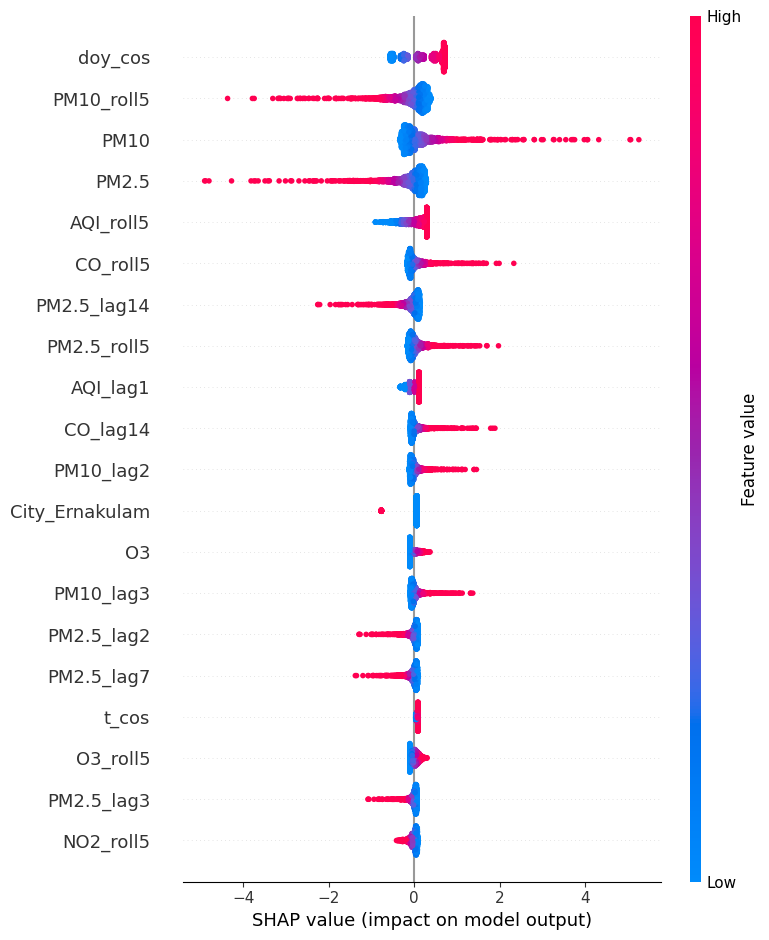

Saved: shap_summary_best_model.png


/tmp/ipython-input-2064058177.py:72: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


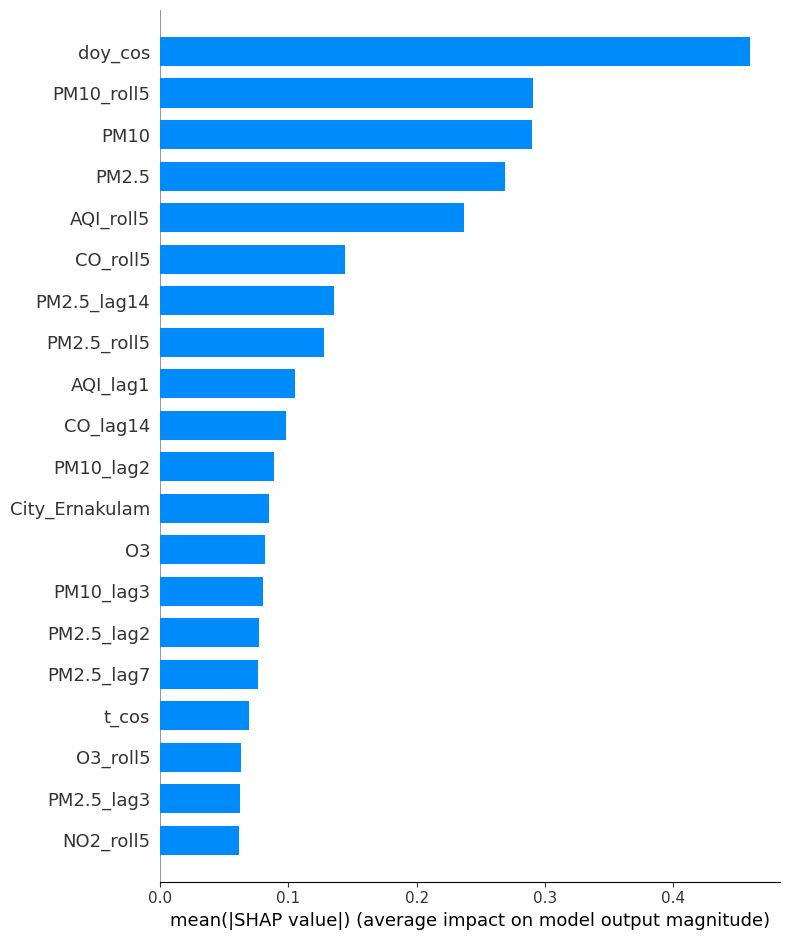

Saved: shap_bar_best_model.png


In [ ]:
import shap

# -------- 1) Prepare feature matrix and names --------
# X_train and X_test should be your *pre-scaled* DataFrames from Step 6.

feature_names = list(X_train.columns) if hasattr(X_train, "columns") else [
    f"f{i}" for i in range(X_train_sc.shape[1])
]

X_bg   = X_train_sc          # background data for SHAP (training set)
X_eval = X_test_sc           # we explain predictions on the test set

# -------- 2) Re-fit the same best classical model for SHAP --------
if best_name == "Linear Regression":
    from sklearn.linear_model import LinearRegression
    model_shap = LinearRegression()
    model_shap.fit(X_bg, y_train)
    explainer = shap.LinearExplainer(model_shap, X_bg)

elif best_name == "Random Forest":
    from sklearn.ensemble import RandomForestRegressor
    model_shap = RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1
    )
    model_shap.fit(X_bg, y_train)
    explainer = shap.TreeExplainer(model_shap)

elif best_name == "XGBoost":
    from xgboost import XGBRegressor
    model_shap = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1,
    )
    model_shap.fit(X_bg, y_train)
    explainer = shap.TreeExplainer(model_shap)

else:
    print(f"SHAP is only implemented here for Linear Regression / Random Forest / XGBoost. "
          f"Best model = {best_name}, skipping SHAP.")
    model_shap = None

# -------- 3) Compute SHAP values and plot --------
if model_shap is not None:
    # compute SHAP values for the test set
    shap_values = explainer(X_eval)

    # summary (beeswarm) plot
    plt.figure(figsize=(10, 5))
    shap.summary_plot(
        shap_values,
        X_eval,
        feature_names=feature_names,
        show=False
    )
    plt.tight_layout()
    plt.savefig("shap_summary_best_model.png", dpi=200)
    plt.show()
    print("Saved: shap_summary_best_model.png")


    plt.figure(figsize=(8, 5))
    shap.summary_plot(
        shap_values,
        X_eval,
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.tight_layout()
    plt.savefig("shap_bar_best_model.png", dpi=200)
    plt.show()
    print("Saved: shap_bar_best_model.png")
